In [111]:
%%html
<style> h1, h2, h3, h4 {font-weight: normal !important;} </style>

In [24]:
# imports

import time
import os
import copy
from pathlib import Path

import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

In [42]:
# config

if Path("/kaggle/input").exists():
    input_dir = Path("/kaggle/input/")
    save_dir = Path("/kaggle/output/")
else:
    input_dir = Path("./dataset/")
    save_dir = Path("./results/")

In [43]:
cudnn.benchmark = True
plt.ion()

# load data

In [44]:
# define transformers
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # mean and std calculated on imagenet dataset
        # mean for [channel1, channel2, channel3] std for [c1, c2, c3]
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "valid": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [45]:
# read dataset with torchvision's ImageFolder method
data_dir = input_dir/"train_images"
source_dataset = datasets.ImageFolder(data_dir)

train_size = int(0.8 * len(source_dataset))
valid_size = len(source_dataset) - train_size

train_set, valid_set = torch.utils.data.random_split(source_dataset, [train_size, valid_size])

In [46]:
# custom dataset to create train and valid datasets
class MakeDataset(torch.utils.data.Dataset):
    
    def __init__(self, sub_dataset, transform=None):
        self.dataset = sub_dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [47]:
# create train and valid datasets
train_set = MakeDataset(train_set, transform=data_transforms["train"])
valid_set = MakeDataset(valid_set, transform=data_transforms["valid"])

In [48]:
# create train and valid dataloaders
train_dl = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2)
valid_dl = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True, num_workers=2)

In [49]:
train_size = len(train_set)
valid_size = len(valid_set)

train_size, valid_size

(8325, 2082)

In [50]:
class_names = source_dataset.classes
class_names

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# visualize few images

In [52]:
def supply_imgs(n=16):
    random_img_idxs = np.random.choice(train_set.dataset.indices, size=n)
    for idx in random_img_idxs:
        yield(source_dataset[idx])

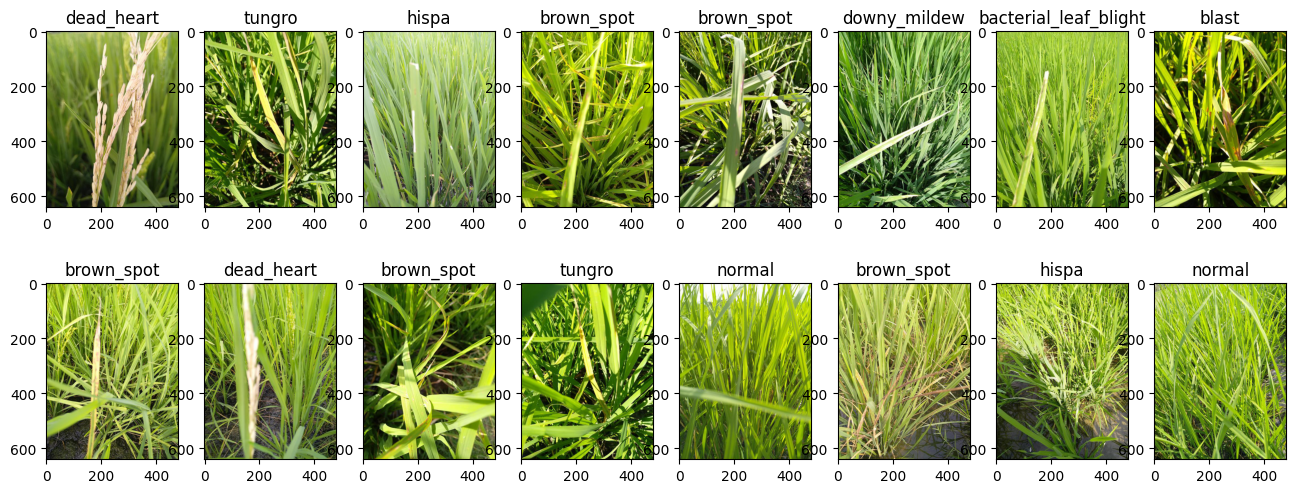

In [53]:
nrows = 2
ncols = 8
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))
supply_imgs_iter = supply_imgs()

for i in range(nrows):
    for j in range(ncols):
        img, label = next(supply_imgs_iter)
        ax[i][j].imshow(img)
        ax[i][j].set_title(train_set.dataset.dataset.classes[label])
plt.show()

# training the model

In [88]:
# define model
model = models.resnet34()  # pretrained resnet 18
num_ftrs = model.fc.in_features  # get in-features in fully connected layer
model.fc = nn.Linear(num_ftrs, 10)  # replace fully connected layer with different out-features (number of target classes here is 10))
model = model.to(device)

In [89]:
# define loss
criterion = nn.CrossEntropyLoss()

In [90]:
# define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [91]:
# define lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## train model

In [92]:
num_epochs = 25

In [93]:
since = time.time()

# save best model weights and accuracy
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch}/{num_epochs-1}")
    print("-" * 10)
    
    for phase in ["train", "valid"]:
        
        if phase == "train":
            dataset_size = train_size
            dataloader = train_dl
        else:
            dataset_size = valid_size
            dataloader = valid_dl
        
        if phase == "train":
            model.train()
        else:
            model.eval()
            
        running_loss = 0.0
        running_corrects = 0
        
        for i, (inputs, labels) in tqdm(enumerate(dataloader), total=dataset_size/16):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()  # zero the parameter gradients
            
            with torch.set_grad_enabled(phase=="train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                if phase == "train":
                    loss.backward()
                    optimizer.step()
                
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds==labels.data)
                
        if phase == "train":
            exp_lr_scheduler.step()

        epoch_loss = running_loss / dataset_size
        epoch_acc = running_corrects.double() / dataset_size

        print(f"{phase} Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}")

        if phase == "valid" and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60}s")
print(f"Best accuracy: {best_acc:.4f}")

model.load_state_dict(best_model_wts)

Epoch 0/24
----------


521it [00:17, 28.98it/s]                                                                           

train Loss: 2.1111 Accuracy: 0.2772



131it [00:05, 24.63it/s]                                                                           

valid Loss: 1.8564 Accuracy: 0.3636
Epoch 1/24
----------



521it [00:18, 28.91it/s]                                                                           

train Loss: 1.8095 Accuracy: 0.3717



131it [00:05, 24.88it/s]                                                                           

valid Loss: 1.6231 Accuracy: 0.4534
Epoch 2/24
----------



521it [00:17, 29.22it/s]                                                                           

train Loss: 1.6678 Accuracy: 0.4274



131it [00:05, 24.68it/s]                                                                           

valid Loss: 1.4602 Accuracy: 0.5048
Epoch 3/24
----------



521it [00:17, 29.49it/s]                                                                           

train Loss: 1.5485 Accuracy: 0.4756



131it [00:05, 24.74it/s]                                                                           

valid Loss: 1.3223 Accuracy: 0.5375
Epoch 4/24
----------



521it [00:17, 28.97it/s]                                                                           

train Loss: 1.4431 Accuracy: 0.5044



131it [00:05, 24.59it/s]                                                                           

valid Loss: 1.3360 Accuracy: 0.5581
Epoch 5/24
----------



521it [00:18, 28.78it/s]                                                                           

train Loss: 1.3445 Accuracy: 0.5427



131it [00:05, 24.59it/s]                                                                           

valid Loss: 1.3055 Accuracy: 0.5644
Epoch 6/24
----------



521it [00:18, 27.94it/s]                                                                           

train Loss: 1.2696 Accuracy: 0.5683



131it [00:05, 24.30it/s]                                                                           

valid Loss: 1.1020 Accuracy: 0.6489
Epoch 7/24
----------



521it [00:17, 29.11it/s]                                                                           

train Loss: 1.0671 Accuracy: 0.6405



131it [00:05, 24.44it/s]                                                                           

valid Loss: 0.7579 Accuracy: 0.7464
Epoch 8/24
----------



521it [00:18, 28.81it/s]                                                                           

train Loss: 1.0007 Accuracy: 0.6625



131it [00:05, 24.51it/s]                                                                           

valid Loss: 0.6809 Accuracy: 0.7805
Epoch 9/24
----------



521it [00:18, 28.85it/s]                                                                           

train Loss: 0.9617 Accuracy: 0.6753



131it [00:05, 24.43it/s]                                                                           

valid Loss: 0.6732 Accuracy: 0.7781
Epoch 10/24
----------



521it [00:18, 28.74it/s]                                                                           

train Loss: 0.9340 Accuracy: 0.6870



131it [00:05, 24.10it/s]                                                                           

valid Loss: 0.6429 Accuracy: 0.7815
Epoch 11/24
----------



521it [00:18, 28.82it/s]                                                                           

train Loss: 0.8983 Accuracy: 0.6977



131it [00:05, 24.73it/s]                                                                           

valid Loss: 0.6206 Accuracy: 0.8055
Epoch 12/24
----------



521it [00:17, 29.00it/s]                                                                           

train Loss: 0.8720 Accuracy: 0.7049



131it [00:05, 24.34it/s]                                                                           

valid Loss: 0.6129 Accuracy: 0.7997
Epoch 13/24
----------



521it [00:18, 28.50it/s]                                                                           

train Loss: 0.8545 Accuracy: 0.7156



131it [00:05, 24.16it/s]                                                                           

valid Loss: 0.5422 Accuracy: 0.8170
Epoch 14/24
----------



521it [00:18, 28.80it/s]                                                                           

train Loss: 0.7901 Accuracy: 0.7385



131it [00:05, 24.77it/s]                                                                           

valid Loss: 0.5404 Accuracy: 0.8237
Epoch 15/24
----------



521it [00:17, 29.10it/s]                                                                           

train Loss: 0.8150 Accuracy: 0.7236



131it [00:05, 24.76it/s]                                                                           

valid Loss: 0.5035 Accuracy: 0.8410
Epoch 16/24
----------



521it [00:18, 28.89it/s]                                                                           

train Loss: 0.7800 Accuracy: 0.7404



131it [00:05, 24.68it/s]                                                                           

valid Loss: 0.4968 Accuracy: 0.8405
Epoch 17/24
----------



521it [00:18, 28.81it/s]                                                                           

train Loss: 0.7643 Accuracy: 0.7474



131it [00:05, 24.66it/s]                                                                           

valid Loss: 0.5191 Accuracy: 0.8338
Epoch 18/24
----------



521it [00:17, 29.23it/s]                                                                           

train Loss: 0.7578 Accuracy: 0.7464



131it [00:05, 24.84it/s]                                                                           

valid Loss: 0.4793 Accuracy: 0.8482
Epoch 19/24
----------



521it [00:18, 28.94it/s]                                                                           

train Loss: 0.7643 Accuracy: 0.7467



131it [00:05, 24.42it/s]                                                                           

valid Loss: 0.4918 Accuracy: 0.8439
Epoch 20/24
----------



521it [00:18, 28.82it/s]                                                                           

train Loss: 0.7550 Accuracy: 0.7440



131it [00:05, 24.77it/s]                                                                           

valid Loss: 0.4818 Accuracy: 0.8391
Epoch 21/24
----------



521it [00:18, 28.73it/s]                                                                           

train Loss: 0.7561 Accuracy: 0.7476



131it [00:05, 24.57it/s]                                                                           

valid Loss: 0.4790 Accuracy: 0.8425
Epoch 22/24
----------



521it [00:18, 28.75it/s]                                                                           

train Loss: 0.7409 Accuracy: 0.7550



131it [00:05, 24.60it/s]                                                                           

valid Loss: 0.4851 Accuracy: 0.8477
Epoch 23/24
----------



521it [00:18, 28.82it/s]                                                                           

train Loss: 0.7478 Accuracy: 0.7485



131it [00:05, 24.49it/s]                                                                           

valid Loss: 0.4727 Accuracy: 0.8458
Epoch 24/24
----------



521it [00:17, 29.08it/s]                                                                           

train Loss: 0.7577 Accuracy: 0.7476



131it [00:05, 24.47it/s]                                                                           

valid Loss: 0.4687 Accuracy: 0.8477
Training complete in 9m 46.840070962905884s
Best accuracy: 0.8482


<All keys matched successfully>

In [61]:
# save model

# torch.save(model.state_dict(), save_dir/"torch_baseline")

In [62]:
# load model

model.load_state_dict(torch.load(save_dir/"torch_baseline"))

<All keys matched successfully>

# Predictions

In [63]:
test_dir = input_dir/"test_images"

In [73]:
model.eval()
image_ids = []
predictions = []

for img in tqdm(test_dir.iterdir()):
    image_id = img.name
    img = Image.open(img)
    img = data_transforms["valid"](img)
    img = img.unsqueeze(0).to(device)
    
    prediction = model(img).argmax().item()
    image_ids.append(image_id)
    predictions.append(prediction)

3469it [00:23, 148.72it/s]


In [84]:
subm_df = pd.DataFrame.from_dict(dict(zip(image_ids, predictions)), orient="index").reset_index()
subm_df.columns = ["image_id", "label"]
subm_df.head()

,image_id,label
0,200761.jpg,7
1,201036.jpg,6
2,201042.jpg,3
3,203280.jpg,9
4,200126.jpg,8


In [87]:
subm_df.to_csv(save_dir/"pytorch_baseline.csv", index=False)